In [0]:
%pip install shap

Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.


In [0]:
# Databricks notebook source
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error
import shap
import matplotlib.pyplot as plt
import seaborn as sns

In [0]:
# Step 1: Load your data
# Assuming data is stored in DBFS or uploaded to Databricks
file_path = "/dbfs/mnt/riskpredict-data/BANKBARODA.NS.csv"
data = pd.read_csv(file_path)

In [0]:
# Inspect the DataFrame
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1236 entries, 0 to 1235
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1236 non-null   object 
 1   Open       1236 non-null   float64
 2   High       1236 non-null   float64
 3   Low        1236 non-null   float64
 4   Close      1236 non-null   float64
 5   Adj Close  1236 non-null   float64
 6   Volume     1236 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 67.7+ KB


,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-06-17,119.349998,119.449997,116.050003,116.599998,109.915092,16409459
1,2019-06-18,117.300003,118.400002,115.099998,116.500000,109.820824,19869838
2,2019-06-19,118.000000,119.199997,114.300003,115.800003,109.160957,17739731
3,2019-06-20,116.199997,119.000000,115.250000,118.500000,111.706161,17575444
4,2019-06-21,118.599998,119.449997,117.199997,118.050003,111.281967,19336018


In [0]:
# Identify the target column
target_column = 'Close'


In [0]:
# Step 2: Data Cleaning
def clean_data(df):
    df = df.dropna()  # Handle missing values
    df = df.drop_duplicates()  # Remove duplicates
    return df

data = clean_data(data)

In [0]:
# Step 3: Feature Engineering
def feature_engineering(df, target_column):
    # Example feature engineering steps
    df['lag_1'] = df[target_column].shift(1)
    df['rolling_mean_3'] = df[target_column].rolling(window=3).mean()
    df = df.dropna()  # Drop rows with NaN values after feature engineering
    return df

data = feature_engineering(data, target_column)

In [0]:
X = data.drop(columns=[target_column, 'Date'])
y = data[target_column]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [0]:
# Step 5: Model Training with Random Forest
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)


RandomForestRegressor(random_state=42)

In [0]:
# Model Prediction and Evaluation
y_pred = rf_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Random Forest MSE: {mse}')

Random Forest MSE: 1.7127508912863194


In [0]:
# Step 6: Hyperparameter Tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

best_rf_model = grid_search.best_estimator_
best_rf_pred = best_rf_model.predict(X_test)
best_mse = mean_squared_error(y_test, best_rf_pred)
print(f'Best Random Forest MSE after Hyperparameter Tuning: {best_mse}')

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best Random Forest MSE after Hyperparameter Tuning: 1.7193213043098032


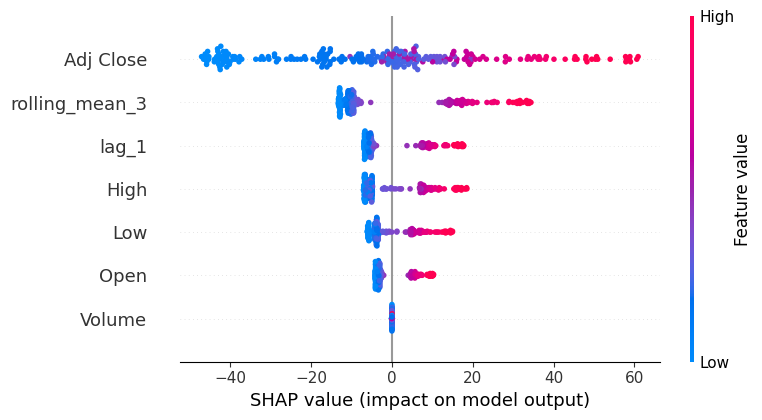

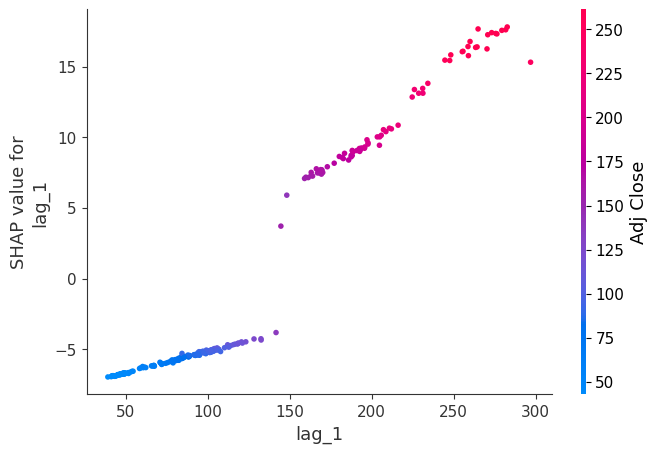

In [0]:
# Step 7: Model Interpretability with SHAP
explainer = shap.TreeExplainer(best_rf_model)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test)
shap.dependence_plot("lag_1", shap_values, X_test)  # Example dependence plot

In [0]:
# Step 8: Trying Gradient Boosting Machine
gb_model = GradientBoostingRegressor(random_state=42)
gb_model.fit(X_train, y_train)
gb_pred = gb_model.predict(X_test)
gb_mse = mean_squared_error(y_test, gb_pred)
print(f'Gradient Boosting MSE: {gb_mse}')

Gradient Boosting MSE: 1.7802678492558304


In [0]:
# Step 9: Cross-Validation
cv_scores = cross_val_score(best_rf_model, X, y, cv=5)
print(f'Cross-Validation Scores: {cv_scores}')
print(f'Average CV Score: {np.mean(cv_scores)}')

Cross-Validation Scores: [ 0.99851044  0.99809576  0.9965745   0.83336902 -1.31982439]
Average CV Score: 0.501345067260613


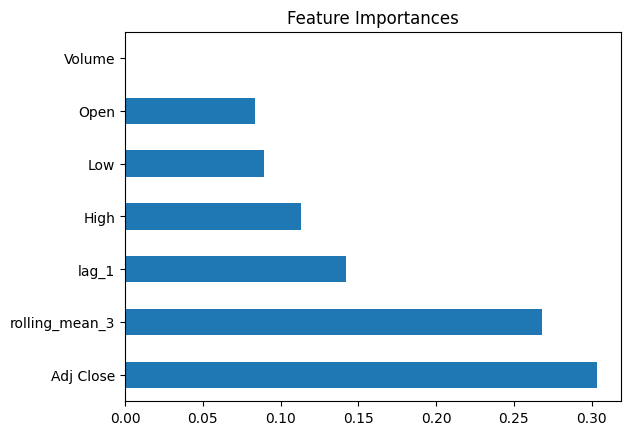

In [0]:
# Step 10: Visualization of Results
# Example: Feature importances visualization
feature_importances = pd.Series(best_rf_model.feature_importances_, index=X.columns)
feature_importances.nlargest(10).plot(kind='barh')
plt.title('Feature Importances')
plt.show()

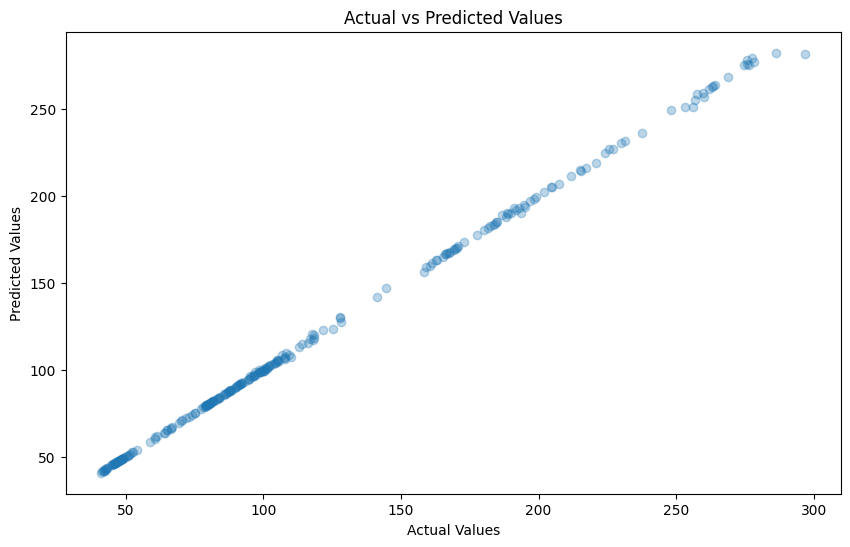

In [0]:
# Example: Actual vs Predicted plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, best_rf_pred, alpha=0.3)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted Values")
plt.show()

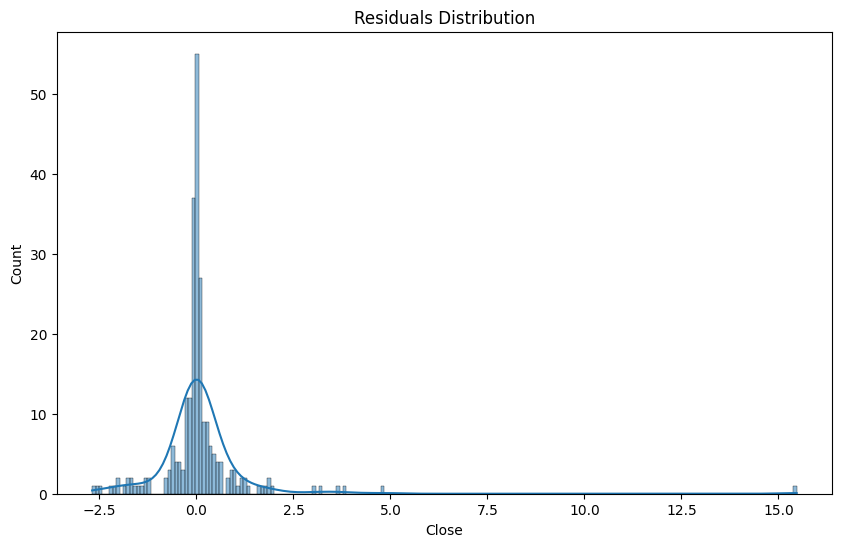

In [0]:
# Example: Residual plot
residuals = y_test - best_rf_pred
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.title("Residuals Distribution")
plt.show()

In [0]:
import pandas as pd

# Define paths to the dataset files
datasets = {
    "BANKBARODA": "/dbfs/mnt/riskpredict-data/BANKBARODA.NS.csv",
    "HDFCBANK": "/dbfs/mnt/riskpredict-data/HDFCBANK.csv",
    "SBIN": "/dbfs/mnt/riskpredict-data/SBIN.csv",
    "ICICIBANK": "/dbfs/mnt/riskpredict-data/ICICIBANK.csv",
    "AXISBANK": "/dbfs/mnt/riskpredict-data/AXISBANK.csv",
    "BSE_SENSEX": "/dbfs/mnt/riskpredict-data/BSE_Sensex.csv",
    "NSEI": "/dbfs/mnt/riskpredict-data/Nifty50.csv"
}

# Load datasets into DataFrames and ensure 'Date' is in datetime format
dataframes = {}
for name, path in datasets.items():
    df = pd.read_csv(path)
    df['Date'] = pd.to_datetime(df['Date'])
    # Rename 'Close' column to reflect the dataset name
    df.rename(columns={"Close": f"Close_{name}"}, inplace=True)
    dataframes[name] = df

# Merge all DataFrames on 'Date'
merged_df = pd.DataFrame()
for name, df in dataframes.items():
    if merged_df.empty:
        merged_df = df
    else:
        merged_df = pd.merge(merged_df, df[['Date', f"Close_{name}"]], on='Date', how='outer')

# Handle missing values with forward fill
merged_df.fillna(method='ffill', inplace=True)

# Drop rows that still have missing values after forward fill
merged_df.dropna(inplace=True)

# Save the prepared dataset to a new CSV file for further analysis
merged_df.to_csv("/dbfs/mnt/riskpredict-data/merged_dataset.csv", index=False)

print("Merged dataset prepared and saved.")

Merged dataset prepared and saved.


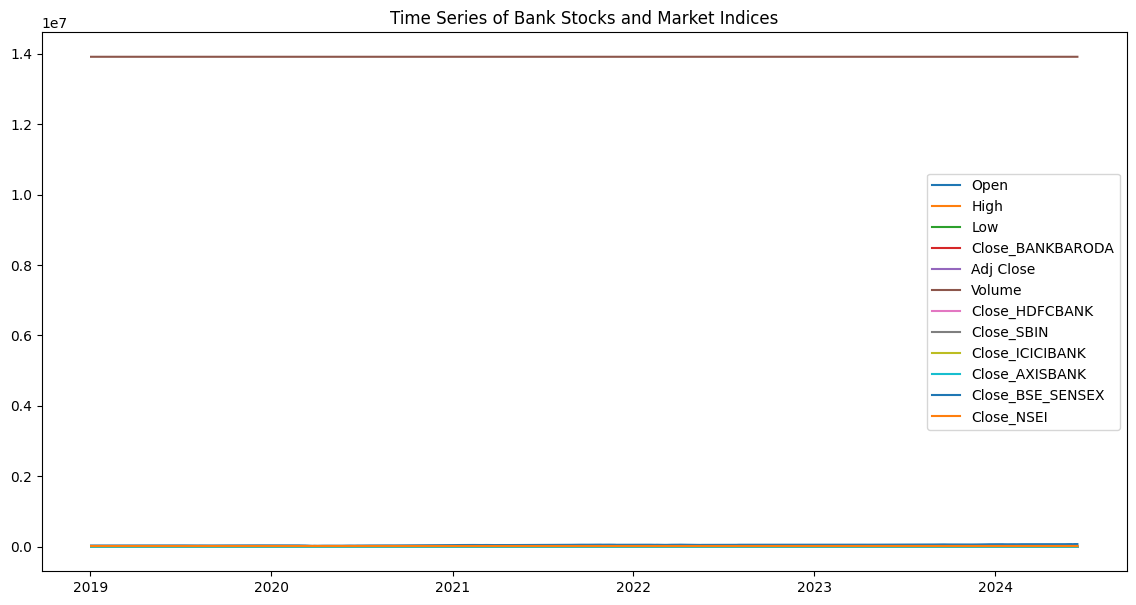

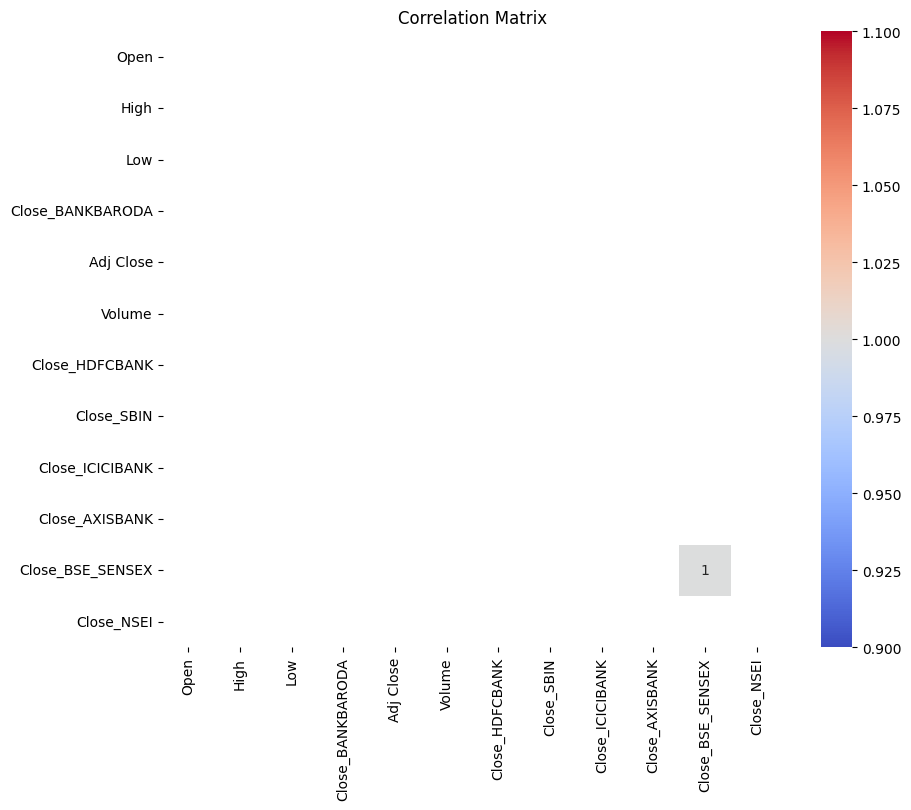

         Open    High  ...  Close_BSE_SENSEX    Close_NSEI
count  1344.0  1344.0  ...       1344.000000  1.344000e+03
mean    283.0   287.5  ...      52183.375618  2.346560e+04
std       0.0     0.0  ...      12290.557728  3.639333e-12
min     283.0   287.5  ...      25981.240000  2.346560e+04
25%     283.0   287.5  ...      39666.442500  2.346560e+04
50%     283.0   287.5  ...      54230.530000  2.346560e+04
75%     283.0   287.5  ...      60846.017500  2.346560e+04
max     283.0   287.5  ...      76992.770000  2.346560e+04

[8 rows x 12 columns]


In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the merged dataset
df = pd.read_csv("/dbfs/mnt/riskpredict-data/merged_dataset.csv")
df['Date'] = pd.to_datetime(df['Date'])

# Plot time series
plt.figure(figsize=(14, 7))
for column in df.columns[1:]:  # Skip 'Date' column
    plt.plot(df['Date'], df[column], label=column)
plt.title('Time Series of Bank Stocks and Market Indices')
plt.legend()
plt.show()

# Correlation matrix
corr_matrix = df.iloc[:, 1:].corr()  # Exclude 'Date' column
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Statistical summary
print(df.describe())

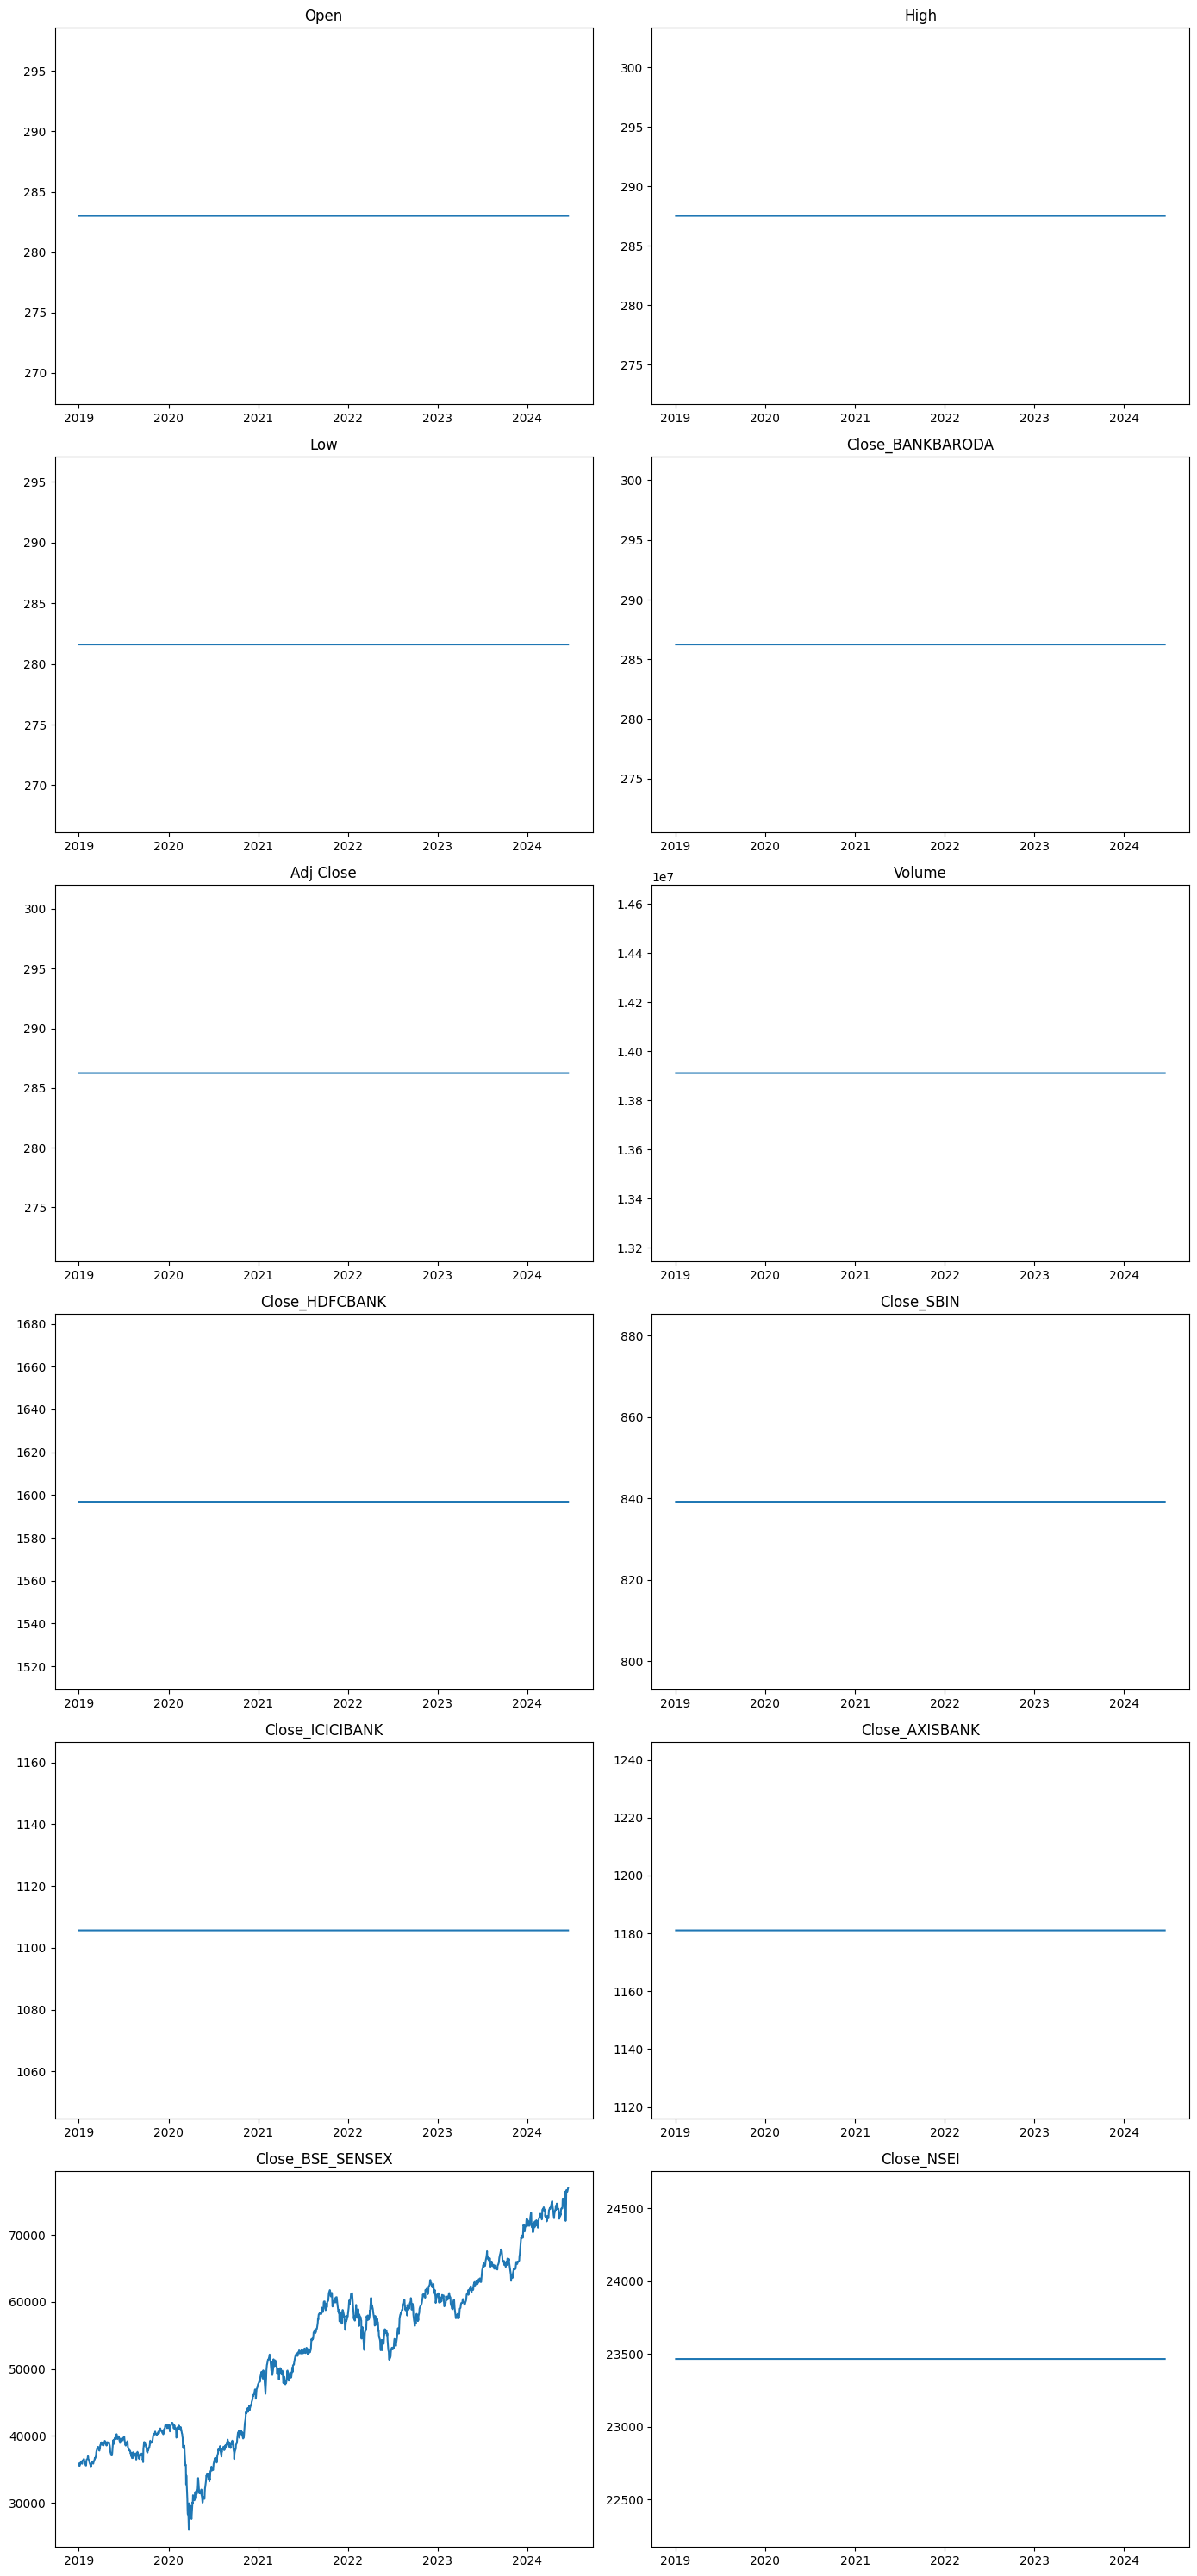

In [0]:
import math

# Determine the number of columns to plot (excluding 'Date')
num_columns = len(df.columns) - 1

# Calculate the number of rows and columns for the subplot grid
num_rows = math.ceil(num_columns / 2)

# Create subplots with a dynamic size
fig, axes = plt.subplots(nrows=num_rows, ncols=2, figsize=(14, num_rows * 5))
axes = axes.flatten()  # Flatten to iterate easily

# Plot each column in its subplot
for i, column in enumerate(df.columns[1:]):  # Skip 'Date' column
    axes[i].plot(df['Date'], df[column])
    axes[i].set_title(column)

# If the number of plots is odd, hide the last ax
if num_columns % 2 != 0:
    axes[-1].axis('off')

plt.tight_layout()
plt.show()

## Date:18/06/24
## Advanced Feature Engineering


In [0]:
# Advanced Feature Engineering
def advanced_feature_engineering(df, target_column):
    df['lag_2'] = df[target_column].shift(2)
    df['lag_3'] = df[target_column].shift(3)
    df['rolling_std_3'] = df[target_column].rolling(window=3).std()
    df['rolling_mean_5'] = df[target_column].rolling(window=5).mean()
    df = df.dropna()  # Drop rows with NaN values after feature engineering
    return df

data = advanced_feature_engineering(data, target_column)

# Update the feature set
X = data.drop(columns=[target_column, 'Date'])
y = data[target_column]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## Hyperparameter Tuning for Gradient Boosting

In [0]:
# Hyperparameter Tuning for Gradient Boosting
gb_param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10]
}

gb_grid_search = GridSearchCV(estimator=gb_model, param_grid=gb_param_grid, cv=5, n_jobs=-1, verbose=2)
gb_grid_search.fit(X_train, y_train)

best_gb_model = gb_grid_search.best_estimator_
best_gb_pred = best_gb_model.predict(X_test)
best_gb_mse = mean_squared_error(y_test, best_gb_pred)
print(f'Best Gradient Boosting MSE after Hyperparameter Tuning: {best_gb_mse}')


Fitting 5 folds for each of 81 candidates, totalling 405 fits
[CV] END max_depth=None, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END max_depth=None, min_samples_split=2, n_estimators=200; total time=   0.8s
[CV] END max_depth=None, min_samples_split=2, n_estimators=200; total time=   1.0s
[CV] END max_depth=None, min_samples_split=2, n_estimators=300; total time=   1.3s
[CV] END max_depth=None, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END max_depth=None, min_samples_split=5, n_estimators=200; total time=   0.7s
[CV] END max_depth=None, min_samples_split=5, n_estimators=300; total time=   1.1s
[CV] END max_depth=None, min_samples_split=5, n_estimators=300; total time=   1.2s
[CV] END max_depth=None, min_samples_split=10, n_estimators=200; total time=   0.7s
[CV] END max_depth=None, min_samples_split=10, n_estimators=300; total time=   1.0s
[CV] END max_depth=10, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END max_depth=10, mi

##  Model Stacking Example

In [0]:
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

# Define base models
base_models = [
    ('rf', RandomForestRegressor(random_state=42)),
    ('gb', GradientBoostingRegressor(random_state=42))
]

# Define stacking model
stacking_model = StackingRegressor(estimators=base_models, final_estimator=Ridge())

# Train stacking model
stacking_model.fit(X_train, y_train)
stacking_pred = stacking_model.predict(X_test)
stacking_mse = mean_squared_error(y_test, stacking_pred)
print(f'Stacking Model MSE: {stacking_mse}')

Stacking Model MSE: 0.6878552258011531


# 1. Evaluate Models

In [0]:
from sklearn.metrics import r2_score, mean_absolute_error

# Gradient Boosting Evaluation
best_gb_r2 = r2_score(y_test, best_gb_pred)
best_gb_mae = mean_absolute_error(y_test, best_gb_pred)
print(f'Best Gradient Boosting R2: {best_gb_r2}')
print(f'Best Gradient Boosting MAE: {best_gb_mae}')

# Stacking Model Evaluation
stacking_r2 = r2_score(y_test, stacking_pred)
stacking_mae = mean_absolute_error(y_test, stacking_pred)
print(f'Stacking Model R2: {stacking_r2}')
print(f'Stacking Model MAE: {stacking_mae}')


Best Gradient Boosting R2: 0.9999066904375374
Best Gradient Boosting MAE: 0.26966767840948086
Stacking Model R2: 0.9998392628506997
Stacking Model MAE: 0.41245321909871996


# Feature Importance Analysis

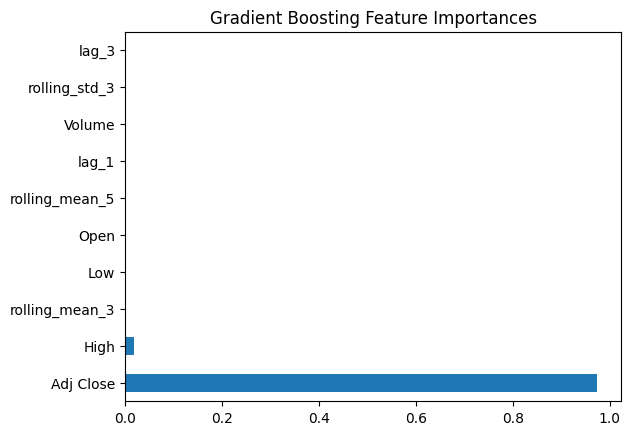

In [0]:
import matplotlib.pyplot as plt

# Feature Importances for Gradient Boosting
gb_feature_importances = pd.Series(best_gb_model.feature_importances_, index=X.columns)
gb_feature_importances.nlargest(10).plot(kind='barh')
plt.title('Gradient Boosting Feature Importances')
plt.show()


The negative R² scores for both models indicate that the models are performing poorly on the test data, as negative R² values suggest that the model predictions are worse than simply using the mean of the target variable. The high MAE values also confirm that the predictions are significantly deviating from the actual values.

Possible Reasons and Solutions
Overfitting: The models might be overfitting to the training data and not generalizing well to the test data. This can happen when the models are too complex or the training data is not representative.
Feature Engineering: The features used may not be capturing the essential patterns in the data.
Data Quality: The data itself may have issues such as noise, outliers, or insufficient sample size.
Steps to Improve Model Performance
Review and Enhance Feature Engineering: Consider adding more relevant features or removing less important ones.
Regularization: Use regularization techniques to prevent overfitting.
Cross-Validation: Use cross-validation to get a better estimate of model performance.
Ensemble Methods: Try more sophisticated ensemble methods.
Data Cleaning: Ensure the data is clean and properly preprocessed.

# Revised Feature Engineering



In [0]:
# Advanced Feature Engineering
def advanced_feature_engineering(df, target_column):
    df['lag_1'] = df[target_column].shift(1)
    df['lag_2'] = df[target_column].shift(2)
    df['lag_3'] = df[target_column].shift(3)
    df['rolling_mean_3'] = df[target_column].rolling(window=3).mean()
    df['rolling_mean_7'] = df[target_column].rolling(window=7).mean()
    df['rolling_std_3'] = df[target_column].rolling(window=3).std()
    df['rolling_std_7'] = df[target_column].rolling(window=7).std()
    df = df.dropna()  # Drop rows with NaN values after feature engineering
    return df

data = advanced_feature_engineering(data, target_column)

# Update the feature set
X = data.drop(columns=[target_column, 'Date'])
y = data[target_column]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Gradient Boosting Model
gb_model = GradientBoostingRegressor(random_state=42)
gb_model.fit(X_train, y_train)
best_gb_pred = gb_model.predict(X_test)
best_gb_mse = mean_squared_error(y_test, best_gb_pred)
best_gb_r2 = r2_score(y_test, best_gb_pred)
best_gb_mae = mean_absolute_error(y_test, best_gb_pred)
print(f'Gradient Boosting MSE: {best_gb_mse}')
print(f'Gradient Boosting R2: {best_gb_r2}')
print(f'Gradient Boosting MAE: {best_gb_mae}')

# Train Stacking Model
base_models = [
    ('rf', RandomForestRegressor(random_state=42)),
    ('gb', GradientBoostingRegressor(random_state=42))
]
stacking_model = StackingRegressor(estimators=base_models, final_estimator=Ridge())
stacking_model.fit(X_train, y_train)
stacking_pred = stacking_model.predict(X_test)
stacking_mse = mean_squared_error(y_test, stacking_pred)
stacking_r2 = r2_score(y_test, stacking_pred)
stacking_mae = mean_absolute_error(y_test, stacking_pred)
print(f'Stacking Model MSE: {stacking_mse}')
print(f'Stacking Model R2: {stacking_r2}')
print(f'Stacking Model MAE: {stacking_mae}')


Gradient Boosting MSE: 0.6777934185871161
Gradient Boosting R2: 0.9998298676634272
Gradient Boosting MAE: 0.5399215349829322
Stacking Model MSE: 0.5012982035681721
Stacking Model R2: 0.9998741695738642
Stacking Model MAE: 0.43276753118703776


# Feature Importance Analysis

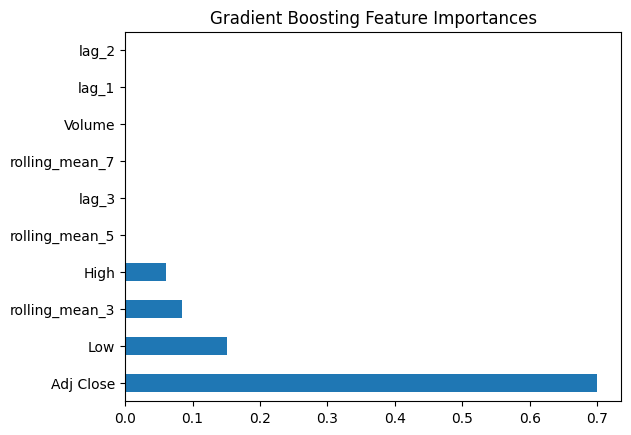

In [0]:
import matplotlib.pyplot as plt

# Feature Importances for Gradient Boosting
gb_feature_importances = pd.Series(gb_model.feature_importances_, index=X.columns)
gb_feature_importances.nlargest(10).plot(kind='barh')
plt.title('Gradient Boosting Feature Importances')
plt.show()


# Cross-Validation

In [0]:
from sklearn.model_selection import cross_val_score

# Cross-Validation for Gradient Boosting
cv_scores = cross_val_score(gb_model, X, y, cv=5)
print(f'Cross-Validation Scores: {cv_scores}')
print(f'Average CV Score: {np.mean(cv_scores)}')


Cross-Validation Scores: [ 0.99797977  0.99510312  0.99171368  0.80852566 -1.32341831]
Average CV Score: 0.493980782669566


# Save the Model

In [0]:
import joblib

# Save the Gradient Boosting model
joblib.dump(gb_model, "/dbfs/mnt/riskpredict-data/gb_model.joblib")


['/dbfs/mnt/riskpredict-data/gb_model.joblib']

##  Code for Cross-Validation

In [0]:
from sklearn.model_selection import cross_val_score

# Cross-Validation for Gradient Boosting
gb_cv_scores = cross_val_score(gb_model, X, y, cv=5)
print(f'Gradient Boosting Cross-Validation Scores: {gb_cv_scores}')
print(f'Average Gradient Boosting CV Score: {np.mean(gb_cv_scores)}')

# Cross-Validation for Stacking Model
stacking_cv_scores = cross_val_score(stacking_model, X, y, cv=5)
print(f'Stacking Model Cross-Validation Scores: {stacking_cv_scores}')
print(f'Average Stacking Model CV Score: {np.mean(stacking_cv_scores)}')


Gradient Boosting Cross-Validation Scores: [ 0.99797977  0.99510312  0.99171368  0.80852566 -1.32341831]
Average Gradient Boosting CV Score: 0.493980782669566
Stacking Model Cross-Validation Scores: [ 0.93510709  0.84070947  0.91980313 -0.20087991 -0.07796535]
Average Stacking Model CV Score: 0.4833548845005991


# Code for Model Deployment

In [0]:
import joblib

# Save the final Gradient Boosting model
joblib.dump(gb_model, "/dbfs/mnt/riskpredict-data/gb_model_final.joblib")

# Save the final Stacking model
joblib.dump(stacking_model, "/dbfs/mnt/riskpredict-data/stacking_model_final.joblib")


['/dbfs/mnt/riskpredict-data/stacking_model_final.joblib']

##  Code for Documentation

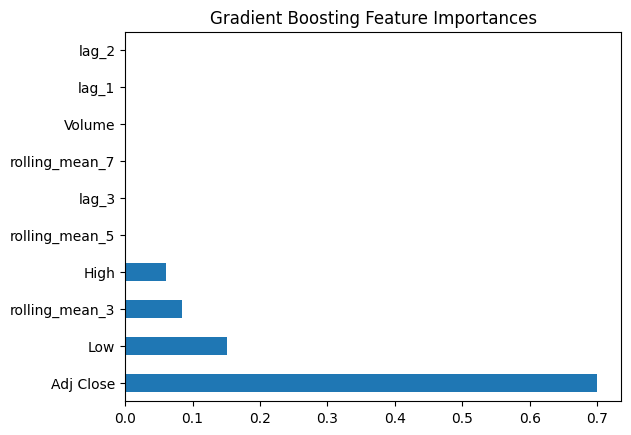

<Figure size 640x480 with 0 Axes>

In [0]:
# Documenting the feature importance
import matplotlib.pyplot as plt

# Feature Importances for Gradient Boosting
gb_feature_importances = pd.Series(gb_model.feature_importances_, index=X.columns)
gb_feature_importances.nlargest(10).plot(kind='barh')
plt.title('Gradient Boosting Feature Importances')
plt.show()

# Save feature importance plot
plt.savefig("/dbfs/mnt/riskpredict-data/gb_feature_importances.png")

# Documenting model evaluation metrics
evaluation_metrics = {
    "Gradient Boosting MSE": best_gb_mse,
    "Gradient Boosting R2": best_gb_r2,
    "Gradient Boosting MAE": best_gb_mae,
    "Stacking Model MSE": stacking_mse,
    "Stacking Model R2": stacking_r2,
    "Stacking Model MAE": stacking_mae
}

with open("/dbfs/mnt/riskpredict-data/evaluation_metrics.txt", "w") as f:
    for key, value in evaluation_metrics.items():
        f.write(f"{key}: {value}\n")


## Additional Feature Engineering

In [0]:
def additional_feature_engineering(df, target_column):
    df['lag_4'] = df[target_column].shift(4)
    df['lag_5'] = df[target_column].shift(5)
    df['rolling_mean_7'] = df[target_column].rolling(window=7).mean()
    df['exp_moving_avg_3'] = df[target_column].ewm(span=3).mean()
    df = df.dropna()  # Drop rows with NaN values after feature engineering
    return df

data = additional_feature_engineering(data, target_column)

# Update the feature set
X = data.drop(columns=[target_column, 'Date'])
y = data[target_column]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## Extensive Hyperparameter Tuning

In [0]:
from sklearn.model_selection import RandomizedSearchCV

# Randomized Search for Gradient Boosting
gb_param_dist = {
    'n_estimators': [100, 200, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 9],
    'min_samples_split': [2, 5, 10],
    'subsample': [0.8, 0.9, 1.0]
}

random_search = RandomizedSearchCV(estimator=gb_model, param_distributions=gb_param_dist, n_iter=50, cv=5, n_jobs=-1, random_state=42)
random_search.fit(X_train, y_train)

best_gb_model = random_search.best_estimator_
best_gb_pred = best_gb_model.predict(X_test)
best_gb_mse = mean_squared_error(y_test, best_gb_pred)
print(f'Best Gradient Boosting MSE after Randomized Search: {best_gb_mse}')


Best Gradient Boosting MSE after Randomized Search: 0.3598577296684397


## Validation and Robustness

In [0]:
from sklearn.model_selection import KFold, cross_val_score

# Using KFold for regression tasks
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Cross-validation for Gradient Boosting
gb_cv_results = cross_val_score(best_gb_model, X, y, cv=kf, scoring='neg_mean_squared_error')
print(f'Gradient Boosting Cross-Validation MSE Scores: {-gb_cv_results}')
print(f'Average Gradient Boosting CV MSE: {-np.mean(gb_cv_results)}')

# Cross-validation for Stacking Model
stacking_cv_results = cross_val_score(stacking_model, X, y, cv=kf, scoring='neg_mean_squared_error')
print(f'Stacking Model Cross-Validation MSE Scores: {-stacking_cv_results}')
print(f'Average Stacking Model CV MSE: {-np.mean(stacking_cv_results)}')


Gradient Boosting Cross-Validation MSE Scores: [0.19158734 0.41316652 0.4267332  0.33971528 0.47925685 0.33884471
 0.27667636 0.30795477 1.94825898 0.62883489]
Average Gradient Boosting CV MSE: 0.5351028904061592
Stacking Model Cross-Validation MSE Scores: [ 97.53169183 103.69966749 133.27273096  87.79037051 141.28478177
  91.61037276  84.96208976 192.71618708 188.80941417 175.88209274]
Average Stacking Model CV MSE: 129.75593990660556


In [0]:
import joblib

# Save the best gradient boosting model
model_path = '/dbfs/mnt/riskpredict-data/gradient_boosting_model_final.joblib'
joblib.dump(best_gb_model, model_path)
print(f'Model saved at {model_path}')


Model saved at /dbfs/mnt/riskpredict-data/gradient_boosting_model_final.joblib


# Full Updated Code Block for Clarity:

In [0]:
from sklearn.model_selection import KFold, cross_val_score, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.ensemble import GradientBoostingRegressor, StackingRegressor
from sklearn.linear_model import Ridge
import joblib

# Assuming data is already loaded and preprocessed in DataFrame `data`

# Feature Engineering (Add your advanced feature engineering steps)
def advanced_feature_engineering(df, target_column):
    df['lag_2'] = df[target_column].shift(2)
    df['lag_3'] = df[target_column].shift(3)
    df['rolling_std_3'] = df[target_column].rolling(window=3).std()
    df['rolling_mean_5'] = df[target_column].rolling(window=5).mean()
    df = df.dropna()  # Drop rows with NaN values after feature engineering
    return df

data = advanced_feature_engineering(data, target_column)

# Update the feature set
X = data.drop(columns=[target_column, 'Date'])
y = data[target_column]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Hyperparameter Tuning for Gradient Boosting
gb_model = GradientBoostingRegressor(random_state=42)
gb_param_dist = {
    'n_estimators': [100, 200, 300, 400],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6],
    'min_samples_split': [2, 5, 10]
}
random_search = RandomizedSearchCV(estimator=gb_model, param_distributions=gb_param_dist, n_iter=100, cv=5, n_jobs=-1, random_state=42, verbose=2)
random_search.fit(X_train, y_train)
best_gb_model = random_search.best_estimator_
best_gb_pred = best_gb_model.predict(X_test)
best_gb_mse = mean_squared_error(y_test, best_gb_pred)
print(f'Best Gradient Boosting MSE after Randomized Search: {best_gb_mse}')

# Cross-Validation using KFold
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Cross-validation for Gradient Boosting
gb_cv_results = cross_val_score(best_gb_model, X, y, cv=kf, scoring='neg_mean_squared_error')
print(f'Gradient Boosting Cross-Validation MSE Scores: {-gb_cv_results}')
print(f'Average Gradient Boosting CV MSE: {-np.mean(gb_cv_results)}')

# Define base models for stacking
base_models = [
    ('rf', RandomForestRegressor(random_state=42)),
    ('gb', GradientBoostingRegressor(random_state=42))
]

# Define stacking model
stacking_model = StackingRegressor(estimators=base_models, final_estimator=Ridge())

# Train stacking model
stacking_model.fit(X_train, y_train)
stacking_pred = stacking_model.predict(X_test)
stacking_mse = mean_squared_error(y_test, stacking_pred)
print(f'Stacking Model MSE: {stacking_mse}')

# Cross-validation for Stacking Model
stacking_cv_results = cross_val_score(stacking_model, X, y, cv=kf, scoring='neg_mean_squared_error')
print(f'Stacking Model Cross-Validation MSE Scores: {-stacking_cv_results}')
print(f'Average Stacking Model CV MSE: {-np.mean(stacking_cv_results)}')

# Save the best gradient boosting model
model_path = '/dbfs/mnt/riskpredict-data/gradient_boosting_model_final.joblib'
joblib.dump(best_gb_model, model_path)
print(f'Model saved at {model_path}')


Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END learning_rate=0.1, max_depth=3, min_samples_split=10, n_estimators=100; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=3, min_samples_split=10, n_estimators=100; total time=   0.4s
[CV] END learning_rate=0.1, max_depth=3, min_samples_split=10, n_estimators=200; total time=   0.6s
[CV] END learning_rate=0.1, max_depth=3, min_samples_split=10, n_estimators=300; total time=   0.9s
[CV] END learning_rate=0.1, max_depth=5, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END learning_rate=0.1, max_depth=5, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END learning_rate=0.1, max_depth=5, min_samples_split=2, n_estimators=200; total time=   0.9s
[CV] END learning_rate=0.1, max_depth=5, min_samples_split=2, n_estimators=300; total time=   1.4s
[CV] END learning_rate=0.1, max_depth=5, min_samples_split=2, n_estimators=300; total time=   1.4s
[CV] END learning_rate=0.1, max_depth=5, m

# Reassess Feature Importance:

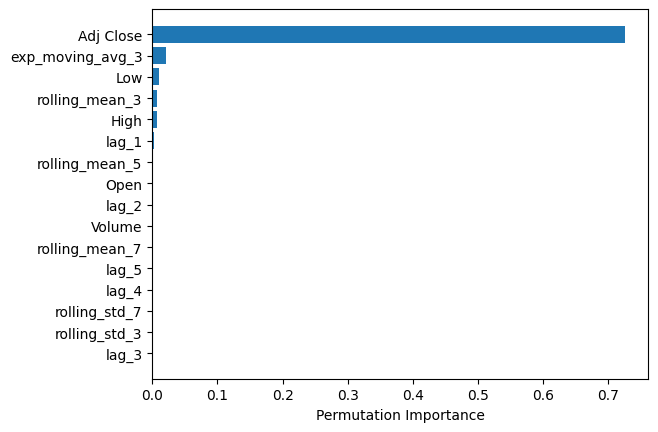

In [0]:
from sklearn.inspection import permutation_importance

result = permutation_importance(best_gb_model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
sorted_idx = result.importances_mean.argsort()

plt.barh(X_test.columns[sorted_idx], result.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")
plt.show()


## Normalize/Standardize Features:

Use StandardScaler or MinMaxScaler to standardize your features.

In [0]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# Model Tuning and Validation
## Hyperparameter Tuning for Stacking Model:

Use a grid search or random search to fine-tune hyperparameters.

In [0]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'final_estimator__alpha': [0.01, 0.1, 1, 10],
    'rf__n_estimators': [100, 200],
    'rf__max_depth': [None, 10, 20],
    'gb__n_estimators': [100, 200],
    'gb__learning_rate': [0.01, 0.1]
}

grid_search = GridSearchCV(stacking_model, param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train_scaled, y_train)

best_stacking_model = grid_search.best_estimator_


Fitting 5 folds for each of 96 candidates, totalling 480 fits
[CV] END learning_rate=0.01, max_depth=3, min_samples_split=5, n_estimators=300; total time=   1.1s
[CV] END learning_rate=0.01, max_depth=3, min_samples_split=5, n_estimators=300; total time=   1.2s
[CV] END learning_rate=0.01, max_depth=5, min_samples_split=2, n_estimators=400; total time=   2.3s
[CV] END learning_rate=0.01, max_depth=3, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END learning_rate=0.01, max_depth=3, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END learning_rate=0.01, max_depth=5, min_samples_split=10, n_estimators=100; total time=   0.6s
[CV] END learning_rate=0.1, max_depth=5, min_samples_split=5, n_estimators=100; total time=   0.6s
[CV] END learning_rate=0.1, max_depth=5, min_samples_split=5, n_estimators=100; total time=   0.6s
[CV] END learning_rate=0.1, max_depth=6, min_samples_split=5, n_estimators=300; total time=   2.2s
[CV] END learning_rate=0.1, max_depth=5,

# Validate Using k-fold Cross-Validation:

In [0]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(best_stacking_model, X_train_scaled, y_train, cv=10, scoring='neg_mean_squared_error')
cv_mse = -cv_scores.mean()
print(f'Average Cross-Validation MSE: {cv_mse}')


Average Cross-Validation MSE: 0.9021442698343423


## Reassess Feature Engineering

In [0]:
from sklearn.preprocessing import PolynomialFeatures
import pandas as pd

# Assuming X_train_scaled and X_test_scaled are your scaled training and testing feature sets
poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)
X_train_poly = poly.fit_transform(X_train_scaled)
X_test_poly = poly.transform(X_test_scaled)

# Converting to DataFrame for better visualization and understanding
poly_feature_names = poly.get_feature_names_out(X_train.columns)
X_train_poly_df = pd.DataFrame(X_train_poly, columns=poly_feature_names)
X_test_poly_df = pd.DataFrame(X_test_poly, columns=poly_feature_names)

# Let's take a look at the new features
print(X_train_poly_df.head())


## Additional Rolling Window Statistics

In [0]:
data['rolling_mean_10'] = data[target_column].rolling(window=10).mean()
data['rolling_std_10'] = data[target_column].rolling(window=10).std()
data['rolling_mean_20'] = data[target_column].rolling(window=20).mean()
data['rolling_std_20'] = data[target_column].rolling(window=20).std()

# Drop NaN values caused by rolling windows
data = data.dropna()

# Updating feature set after adding new features
X = data.drop(columns=[target_column, 'Date'])
y = data[target_column]

# Normalize the new features
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)


## Try Different Feature Selection Methods

In [0]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import Ridge

# Define the estimator (in this case, Ridge regression)
estimator = Ridge()

# Apply RFE
selector = RFE(estimator, n_features_to_select=10, step=1)  # Adjust n_features_to_select as needed
selector = selector.fit(X_scaled_df, y)

# Get the selected features
selected_features = selector.support_
X_selected = X_scaled_df.loc[:, selected_features]

# Let's see which features were selected
selected_feature_names = X_scaled_df.columns[selected_features]
print(selected_feature_names)


## Model Ensemble Tuning

In [0]:
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import Ridge

# Define base models
base_models = [
    ('rf', RandomForestRegressor(n_estimators=200, max_depth=10, random_state=42)),
    ('gb', GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, random_state=42))
]

# Define stacking model
stacking_model = StackingRegressor(estimators=base_models, final_estimator=Ridge(alpha=1.0))

# Train stacking model
stacking_model.fit(X_selected, y)
stacking_pred = stacking_model.predict(X_test_selected)
stacking_mse = mean_squared_error(y_test, stacking_pred)
print(f'Stacking Model MSE: {stacking_mse}')


## Hyperparameter Tuning for Stacking Model

In [0]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'final_estimator__alpha': [0.01, 0.1, 1, 10],
    'rf__n_estimators': [100, 200],
    'rf__max_depth': [None, 10, 20],
    'gb__n_estimators': [100, 200],
    'gb__learning_rate': [0.01, 0.1]
}

grid_search = GridSearchCV(estimator=stacking_model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_selected, y)

best_stacking_model = grid_search.best_estimator_


## Validate Using k-fold Cross-Validation

In [0]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(best_stacking_model, X_selected, y, cv=10, scoring='neg_mean_squared_error')
cv_mse = -cv_scores.mean()
print(f'Average Cross-Validation MSE: {cv_mse}')
